# Geophysical particle filter

The point of this notebook is to recreate on an unclassified dataset and unrelated codebase the deep water bathymetric particle filter results, and include additional results for gravity and magnetic measurements. The function of this notebook is to serve as a prototyping and low-scale 'simulation' environment. 

First, let's import the stuff needed.

In [1]:
import numpy as np
from gmt_tool import get_map_section, inflate_bounds, get_map_point
from haversine import haversine, Unit
from tools import load_trackline_data
from matplotlib import pyplot as plt
from particle_filter import process_particle_filter, propagate, plot_error, plot_estimate, plot_map_and_trajectory
import pandas as pd
from datetime import timedelta
from scipy.io import savemat

First we need to tune the particle filter propagation noise to be similar to that of a marine-grade inertial navigation system. A low-end marine-grade INS should have a drift of 1 nm per 24 hours.

In [ ]:
from particle_filter import rmse

time = 24*60 # minutes
noise = np.array([0, 2.6, 0])
bound = 1852 # meters

errors = []
for v in range(1, 26):
    P = np.asarray([[0,0,0,0,v,0]])
    T = P.copy()
    t = 0
    for i in range(10000):
        # Eastward
        u = [0,v,0]
        while t < time:    
            P = propagate(P, u, noise=np.diag(noise), noise_calibration_mode=True)
            T = propagate(T, u, noise=np.diag([0,0,0]), noise_calibration_mode=False)
            t+=1
        errors.append(rmse(P, T[0, :2]))
        # Northward
        u = [v,0,0]
        while t < time:    
            P = propagate(P, u, noise=np.diag(noise), noise_calibration_mode=True)
            T = propagate(T, u, noise=np.diag([0,0,0]), noise_calibration_mode=False)
            t+=1
        errors.append(rmse(P, T[0, :2]))
        # Northeastward 
        u = np.array([1,1,0]) / np.linalg.norm([1,1,0])
        u *= v
        while t < time:    
            P = propagate(P, u, noise=np.diag(noise), noise_calibration_mode=True)
            T = propagate(T, u, noise=np.diag([0,0,0]), noise_calibration_mode=False)
            t+=1
        errors.append(rmse(P, T[0, :2]))

print(f"RMSE: {np.mean(errors)}")

In [ ]:
plt.hist(errors)
plt.show()

In [ ]:
config = {'velocity_noise':noise.tolist()}

We'll first do some general examination of the data. Namely, investigating the sensor measurements to see if we can build a reasonable sensor model.

In [ ]:
import os

d_bathy = np.asarray([])
d_grav = np.asarray([])
d_mag = np.asarray([])
# walk through all files in the directory and load the .csv files
for root, dirs, files in os.walk('./data/parsed'):
    for file in files:
        if file.endswith('.csv'):
            data = load_trackline_data(os.path.join(root, file))
            name = file.split('.')[0]
            min_lon = data.LON.min()
            max_lon = data.LON.max()
            min_lat = data.LAT.min()
            max_lat = data.LAT.max()
            min_lon, min_lat, max_lon, max_lat = inflate_bounds(min_lon, min_lat, max_lon, max_lat, 0.25)
            bathy_map = get_map_section(min_lon, max_lon, min_lat, max_lat, 'relief', '15s', os.path.join(root, name))
            grav_map = get_map_section(min_lon, max_lon, min_lat, max_lat, 'gravity', '01m', os.path.join(root, name))
            mag_map = get_map_section(min_lon, max_lon, min_lat, max_lat, 'magnetic', '02m', os.path.join(root, name))
            d_bathy = np.hstack([d_bathy, data['CORR_DEPTH'] - (-get_map_point(bathy_map, data.LON, data.LAT))])
            d_grav = np.hstack([data['FREEAIR'] - get_map_point(grav_map, data.LON, data.LAT)])
            d_mag = np.hstack([data['CORR_DEPTH'] - get_map_point(bathy_map, data.LON, data.LAT)])

config['Bathy_mean_d'] = np.mean(d_bathy, where=~np.isnan(d_bathy))
config['Gravity_mean_d'] = np.mean(d_grav, where=~np.isnan(d_grav))
config['Magnetic_mean_d'] = np.mean(d_mag, where=~np.isnan(d_mag))
config['Bathy_std'] = np.std(d_bathy, where=~np.isnan(d_bathy))
config['Gravity_std'] = np.std(d_grav, where=~np.isnan(d_grav)) 
config['Magnetic_std'] = np.std(d_mag, where=~np.isnan(d_mag))  


In [ ]:
import json

In [ ]:
config = {'velocity_noise':noise.tolist()}
config['bathy_mean_d'] = np.mean(d_bathy, where=~np.isnan(d_bathy))
config['gravity_mean_d'] = np.mean(d_grav, where=~np.isnan(d_grav))
config['magnetic_mean_d'] = np.mean(d_mag, where=~np.isnan(d_mag))
config['bathy_std'] = np.std(d_bathy, where=~np.isnan(d_bathy))
config['gravity_std'] = np.std(d_grav, where=~np.isnan(d_grav)) 
config['magnetic_std'] = np.std(d_mag, where=~np.isnan(d_mag))
# compute median and mode for each of the above
config['bathy_median_d'] = np.median(d_bathy)
config['gravity_median_d'] = np.median(d_grav)
config['magnetic_median_d'] = np.median(d_mag)


In [ ]:

# convert config to json and save it to a file
with open('config.json', 'w') as f:
    json.dump(config, f)
    

In [ ]:
import os
path, file = os.path.split("/data/to/read.csv")
path

In [ ]:
name, ext = os.path.splitext(file)

In [ ]:
config['velocity_noise'] = config['velocity_noise'].tolist()

Now let's run the trajectory

In [2]:
import json
config = json.load(open('config.json', 'r'))

gmt grdcut @earth_relief_15s_p -Rd-47.55615/-41.84205/45.7100875/46.7018425 -Gew0007_0.nc
CompletedProcess(args='conda run -n pygmt gmt grdcut @earth_relief_15s_p -Rd-47.55615/-41.84205/45.7100875/46.7018425 -Gew0007_0.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -47.55615 to -47.5583333333\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -41.84205 to -41.8375\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 45.7100875 to 45.7041666667\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 46.7018425 to 46.7041666667\n\n')


/home/james/research/particle_filter.py:98: RuntimeWarning: invalid value encountered in divide
  new_weights = w / w_sum
/home/james/miniconda3/envs/nav/lib/python3.12/site-packages/filterpy/monte_carlo/resampling.py:61: RuntimeWarning: invalid value encountered in cast
  num_copies = (np.floor(N*np.asarray(weights))).astype(int)


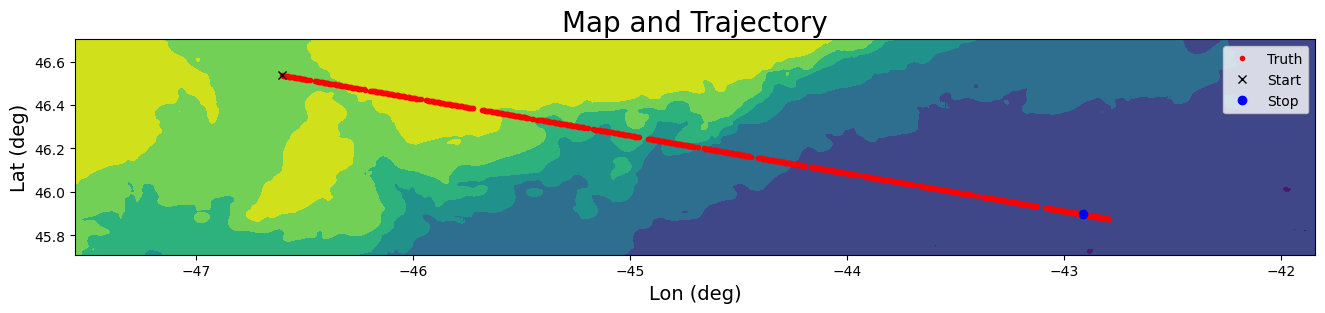

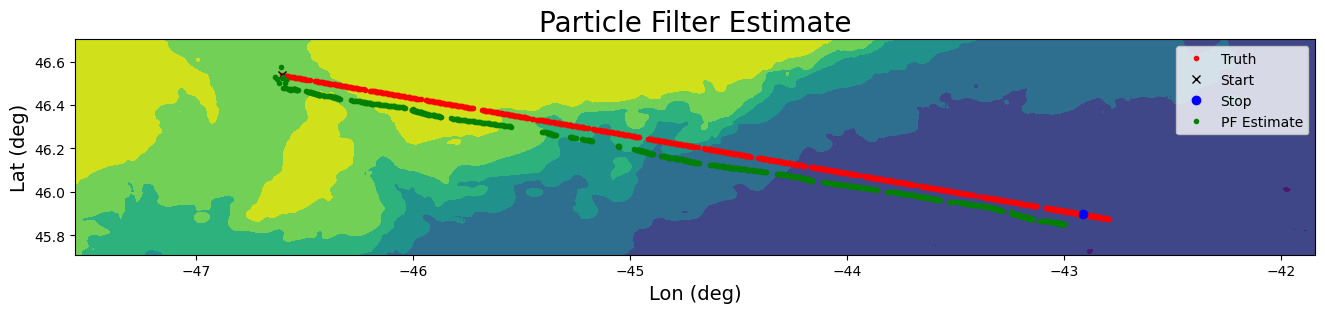

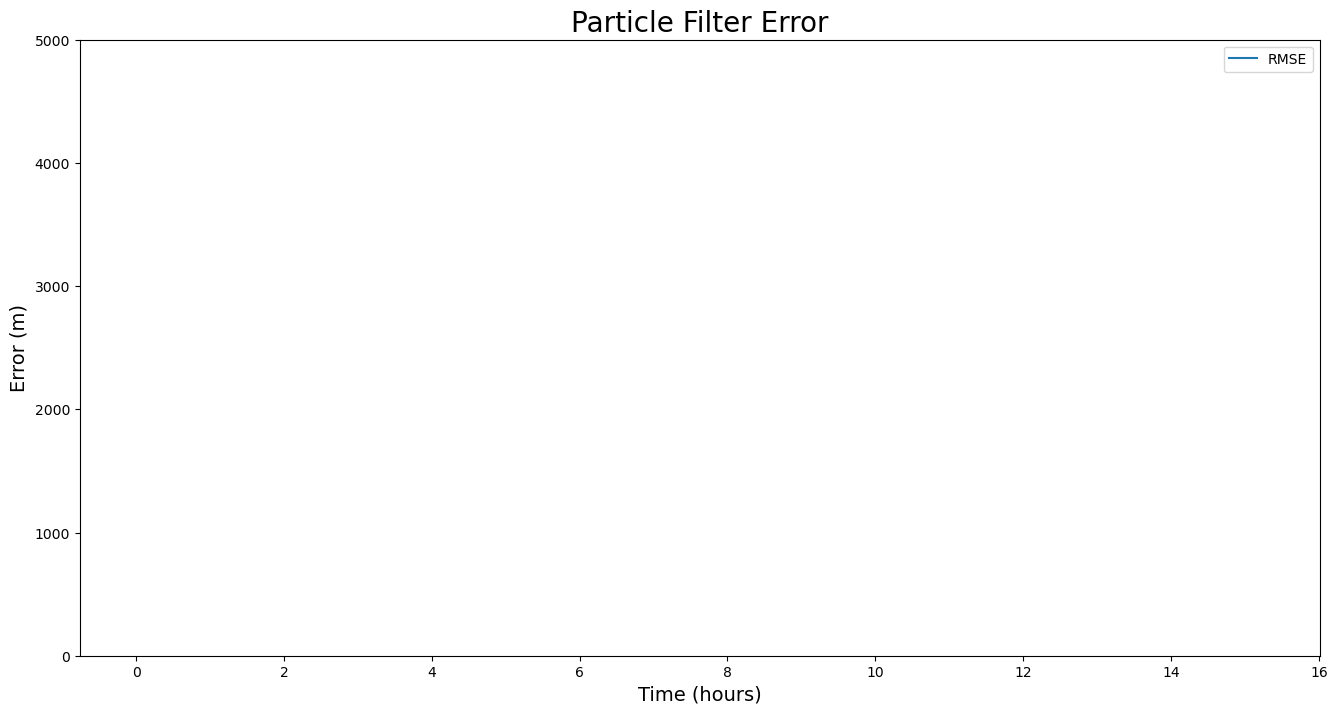

In [3]:
process_particle_filter("./data/parsed/ew0007_0.csv", config, "./results/")

In [ ]:
# Load the trajectory file
data = load_trackline_data("./data/parsed/ew0007_0.csv")
name = "ew0007_0"
# Create the map
min_lon = data.LON.min()
max_lon = data.LON.max()
min_lat = data.LAT.min()
max_lat = data.LAT.max()
min_lon, min_lat, max_lon, max_lat = inflate_bounds(min_lon, min_lat, max_lon, max_lat, 0.25)
geo_map = get_map_section(min_lon, max_lon, min_lat, max_lat, 'relief', '15s', name)

# Run the particle filter
N = 100
# Intial parameters
mu = [data.iloc[0].LAT, data.iloc[0].LON, 0, 0, 0, 0]
cov = np.hstack([[1/60, 1/60, 0], config['velocity_noise']])
cov = np.diag(cov)
# Run PF


In [ ]:
fig, ax = plot_error(data, rms_error, 425)